In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal as signal
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(it, *args, **vargs):
        return it

def qdem(x):
    return np.angle(x[1:] * np.conj(x[:-1])) / (2 * np.pi)

In [190]:
def open_recording_as_raw(filename):
    """
    Open a HackRF or similar recording of I/Q data.
    """
    center_freq = int(filename.split('_')[-3])
    
    num_format = filename.split('_')[-1]
    type_ = None
    scale = 1.0
    if num_format.startswith('i8c'):
        type_ = np.int8
        scale = 1/2**7
    elif num_format.startswith('i16c'):
        type_ = np.int16
        scale = 1/2**15
    elif num_format.startswith('fc'):
        type_ = np.float32
        scale = 1.0
    else:
        raise Exception(f'Unknown recording number format {num_format} in file "{filename}"')
    
    # Read raw interleaved IQ data
    raw_data = np.memmap(filename, dtype=type_, mode='r')
    fs = int(filename.split('_')[-2])
    
    print(f'File: {filename}, sample count: {len(raw_data)} ({len(raw_data)/fs/2:.2f}) seconds)')

    return center_freq, fs, scale, raw_data

def open_recording_as_complex(fname, window_offset=0, window_size=1):
    """
    Open a HackRF or similar recording of I/Q data and narrow to a given window offset and size (in seconds)
    """
    center_freq, fs, scale, raw_data = open_recording_as_raw(fname)

    # in seconds
    start = int(window_offset * fs * 2)
    end = int(start + window_size * fs * 2)
    assert start < len(raw_data), 'start out of bounds'
    window = raw_data[start:end]

    # Reshape into complex values: I (even indices), Q (odd indices)
    iq_data = window.astype(np.float32) * scale
    iq_data = iq_data[0::2] + 1j * iq_data[1::2]

    assert len(iq_data) > 0
    
    return center_freq, fs, iq_data

In [314]:
def detect_frequencies(data, freqs, fs, bandwidth=5_000, noise_neighbors=200_000, threshold_db=10):
    """
    Detect rate that a given complex sample contains certain frequencies (from a given center frequency)
    above the noise level of its neighbors.
    """
    window = np.hanning(len(data))
    windowed_data = data * window

    spectrum = np.fft.fftshift(np.fft.fft(windowed_data))
    frequencies = np.fft.fftshift(np.fft.fftfreq(len(spectrum), d=1/fs))  # adjust for sample rate
    power = 20 * np.log10(np.abs(spectrum) + 1e-10)  # in dB
    result = []
    for freq in freqs:
        neighbors = power[(frequencies >= (freq - noise_neighbors/2)) & (frequencies <= (freq + noise_neighbors/2))]
        neighbors_mean = np.mean(neighbors)
        mask = (frequencies >= (freq - bandwidth/2)) & (frequencies <= (freq + bandwidth/2))
        band = power[mask]
        mean_diff = np.mean(band) - neighbors_mean
        if mean_diff > threshold_db:
            result.append(mean_diff)
        else:
            result.append(0)
    
    return np.array(result)

In [205]:
def detect_dpu_messages(fname, debug_print=False):
    # messages last about 0.5 seconds, so we can sample every 0.2 seconds or so
    center_freq, fs, scale, raw_data = open_recording_as_raw(fname)

    # truncate data for testing
    # raw_data = raw_data[:fs * 20 * 2]

    sample_interval = int(0.2 * fs)
    sample_len = 2048 * 8

    detections = np.zeros((int(np.ceil(len(raw_data)//2/sample_interval)), len(DPU_FREQS) + 1))

    print(f'Processing {len(raw_data)//2//sample_interval} raw samples...')
    # indices are for pairs of values
    for i in range(0, len(raw_data)//2, sample_interval):
        # Reshape into complex values: I (even indices), Q (odd indices)
        iq_data = raw_data[i*2:i*2+sample_len*2].astype(np.float32) * scale
        iq_data = iq_data[0::2] + 1j * iq_data[1::2]
        
        detected = detect_frequencies(iq_data, DPU_FREQS - center_freq, fs)
        seconds = i/fs
        
        detections[i//sample_interval, 0] = seconds
        detections[i//sample_interval, 1:] = detected

        if np.any(detected > 0.05):
            if debug_print:
                s = f'time: {seconds:5.1f}   DPUs:'
                for dpu in detected:
                    s += f' {dpu:.2f}'
                print(s)

    return detections

In [5]:
def draw_dpu_spectrogram(fname, start_time, duration):
    center_freq, fs, iq_data = open_recording_as_complex(fname, start_time, duration)
    
    chunk_size = 2048 * 16
    num_chunks = len(iq_data) // chunk_size
    
    channelset1 = (452.925, 452.95)
    channelset2 = (457.925, 457.95)
    bandwidth = 5e-3 # 5khz
    
    t = np.linspace(start_time, start_time + num_chunks * chunk_size / fs, num_chunks)
    freq1 = None
    freq2 = None
    mesh1 = []
    mesh2 = []
    for i in range(num_chunks):
        data = iq_data[i * chunk_size:(i + 1) * chunk_size]
        window = np.hanning(len(data))
        windowed_data = data * window
        
        # FFT
        spectrum = np.fft.fftshift(np.fft.fft(windowed_data))
        raw_frequencies = np.fft.fftshift(np.fft.fftfreq(len(spectrum), d=1/fs))  # adjust for sample rate
        frequencies = (raw_frequencies + center_freq)/1e6 # in MHz
        power = 20 * np.log10(np.abs(spectrum) + 1e-10)  # in dB
    
        f_min = channelset1[0] - 0.0125 * .5
        f_max = channelset1[1] + 0.0125 * .5
        mask = (frequencies >= f_min) & (frequencies <= f_max)
    
        filtered_freq = frequencies[mask]
        filtered_power = power[mask]
    
        if freq1 is None:
            freq1 = filtered_freq
        mesh1.append(filtered_power)
    
        f_min = channelset2[0] - 0.0125 * .5
        f_max = channelset2[1] + 0.0125 * .5
        mask = (frequencies >= f_min) & (frequencies <= f_max)
    
        filtered_freq = frequencies[mask]
        filtered_power = power[mask]
    
        if freq2 is None:
            freq2 = filtered_freq
        mesh2.append(filtered_power)
    
    mesh1 = np.array(mesh1).T
    mesh2 = np.array(mesh2).T
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    mesh_mappable1 = ax1.pcolormesh(t, freq1, mesh1, vmin=-40, vmax=40)
    
    ax1.set(title='Lower DPU Spectrum', ylabel="Frequency (+452. MHz)", xlabel="Time (sec)")
    ax1.ticklabel_format(useOffset=False)
    yvals = np.array([452.9250, 452.9375, 452.9500])
    ax1.set_yticks(yvals, ['DPU ch1 (.9250)', 'HOT (.9375)', 'DPU ch2 (.9500)'])
    
    fig.colorbar(mesh_mappable1, ax=ax1)
    
    mesh_mappable2 = ax2.pcolormesh(t, freq2, mesh2, vmin=-40, vmax=40)
    
    ax2.set(title='Upper DPU Spectrum', ylabel="Frequency (+457. MHz)", xlabel="Time (sec)")
    ax2.ticklabel_format(useOffset=False)
    yvals = np.array([457.9250, 457.9375, 457.9500])
    ax2.set_yticks(yvals, ['DPU ch3 (.9250)', 'EOT (.9375)', 'DPU ch4 (.9500)'])
    
    fig.colorbar(mesh_mappable2, ax=ax2)
    plt.show()

In [6]:
def draw_freq_spectrum(fname, start_time, window_size=65536, xlim=None):
    duration = 1
    center_freq, fs, iq_data = open_recording_as_complex(fname, start_time, duration)

    data = iq_data[:window_size]
    window = np.hanning(len(data))
    windowed_data = data * window
    
    # FFT
    spectrum = np.fft.fftshift(np.fft.fft(windowed_data))
    frequencies = np.fft.fftshift(np.fft.fftfreq(len(spectrum), d=1/fs))  # adjust for sample rate
    power = 20 * np.log10(np.abs(spectrum) + 1e-10)  # in dB
    
    plt.figure(figsize=(10, 6))

    if xlim is not None:
        plt.xlim(*xlim)
    
    plt.plot((frequencies + center_freq)/1e6, power)
    plt.title("Frequency Spectrum")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Power (dB)")
    plt.show()

In [290]:
def fsk_demodulate(center_freq, fs, iq_data, channel_freq):
    t = np.arange(len(iq_data))
    mixed = iq_data * np.exp(-2j * np.pi * ((channel_freq - center_freq) / fs) * t)
    
    factor = 64
    new_fs = fs // factor
    downsampled = signal.decimate(mixed, factor)
    
    fskbb = signal.lfilter(signal.firwin(81, cutoff=3000, fs=new_fs), 1.0, downsampled)
    
    recovered_signal = qdem(fskbb) * 10
    recovered_signal[:81] = 0
    
    data = recovered_signal
    
    t = np.arange(len(data))
    mixed = data * np.exp(-2j * np.pi * (-1700 / new_fs) * t)
    
    fskbb = signal.lfilter(signal.firwin(201, cutoff=800, fs=new_fs), 1.0, mixed)
    
    recovered_signal = qdem(fskbb) * 40
    recovered_signal[:201] = 0

    return recovered_signal, new_fs

In [8]:
def decode_dpu_bits(fname, start_time, duration, channel_id):
    assert channel_id >= 0 and channel_id <= 3, 'invalid DPU channel'
    channel_freq = DPU_FREQS[channel_id]
    
    frame_sync = '0110111000100110100001'
    
    center_freq, fs, iq_data = open_recording_as_complex(fname, start_time, duration)
    
    fsk, fs = fsk_demodulate(center_freq, fs, iq_data, channel_freq)
    
    # discard extreme values
    fsk[np.abs(fsk) > 0.3] = 0
    
    baudrate = 1200
    frame_sync_bits = np.array([int(c) for c in frame_sync])
    framesync = np.repeat((frame_sync_bits * 2) - 1, fs//baudrate)
    
    # 10 means shift the frame sync by 1/10 of a baud at a time when searching
    frame_sync_discovery_factor = 10
    
    factor = fs//baudrate//frame_sync_discovery_factor
    downsampled_signal = signal.decimate(fsk, factor)
    downsampled_framesync = framesync[::factor]
    
    score = np.convolve(downsampled_signal, downsampled_framesync[::-1], mode='valid')
    framesync_matched = np.argmax(score)
    
    baud_period = fs/factor/baudrate
    indices = np.arange(framesync_matched + baud_period//2, len(downsampled_signal), baud_period).astype(int)
    extracted_data = (np.sign(downsampled_signal[indices]) + 1)/2
    data_bin = ''.join(str(int(c)) for c in extracted_data)
    assert data_bin.startswith(frame_sync), 'was framesync not a perfect match?'

    return data_bin

In [9]:
DPU_FREQS = np.array([452_925_000, 452_950_000, 457_925_000, 457_950_000])

In [318]:
detections = detect_dpu_messages('recordings/gqrx_20250804_210302_455500000_6000000_fc.raw')
detections

File: recordings/gqrx_20250804_210302_455500000_6000000_fc.raw, sample count: 1031798784 (85.98) seconds)
Processing 429 raw samples...


array([[ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0.2,  0. ,  0. ,  0. ,  0. ],
       [ 0.4,  0. ,  0. ,  0. ,  0. ],
       ...,
       [85.4,  0. ,  0. ,  0. ,  0. ],
       [85.6,  0. ,  0. ,  0. ,  0. ],
       [85.8,  0. ,  0. ,  0. ,  0. ]], shape=(430, 5))

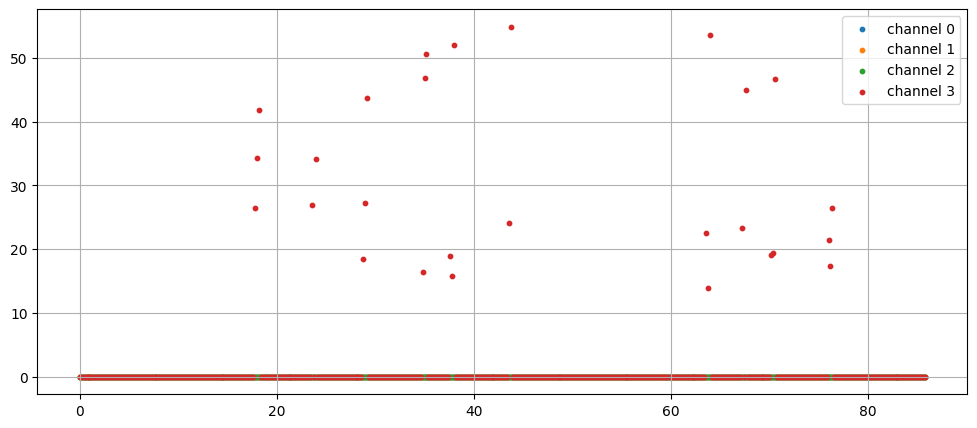

In [319]:
plt.figure(figsize=(12, 5))
for channel in range(4):
    plt.scatter(detections[:,0], detections[:,channel + 1], s=10, label=f'channel {channel}')
plt.legend()
plt.grid()
plt.show()

File: recordings/gqrx_20250804_210302_455500000_6000000_fc.raw, sample count: 1031798784 (85.98) seconds)


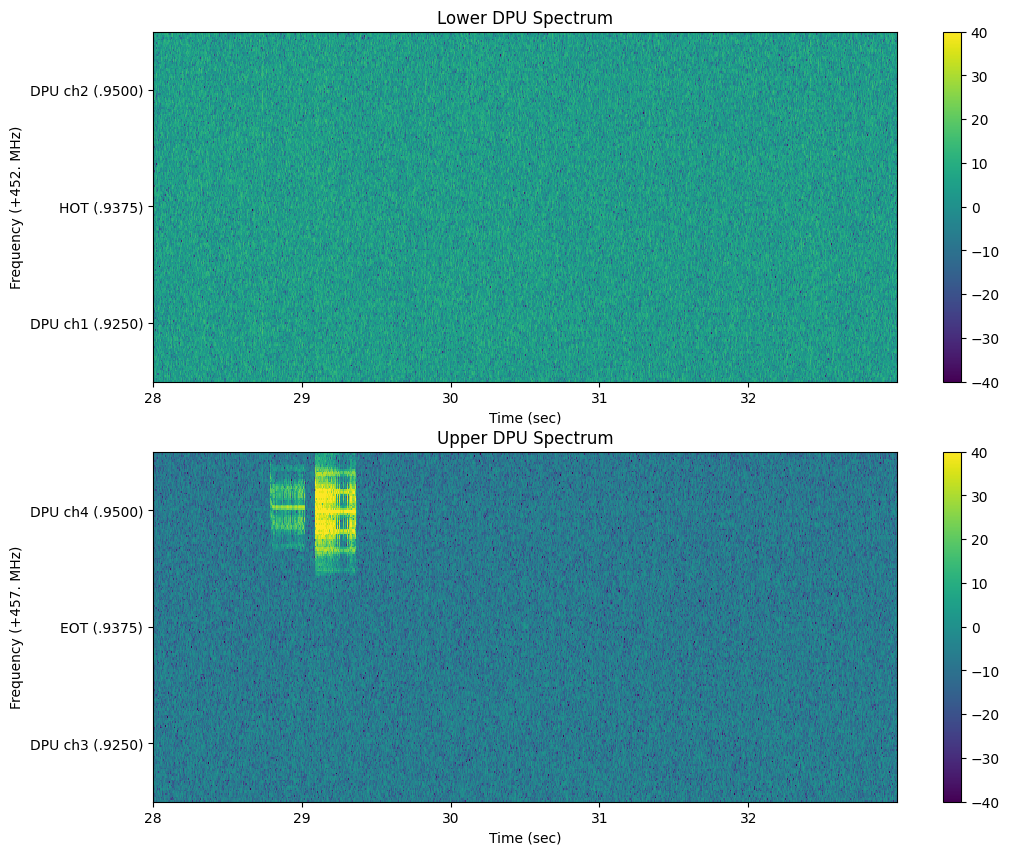

In [310]:
draw_dpu_spectrogram('recordings/gqrx_20250804_210302_455500000_6000000_fc.raw', 28, 5)

File: recordings/hackrf_20250804_155723_455500000_8000000_i8c.raw, sample count: 1492123648 (93.26) seconds)


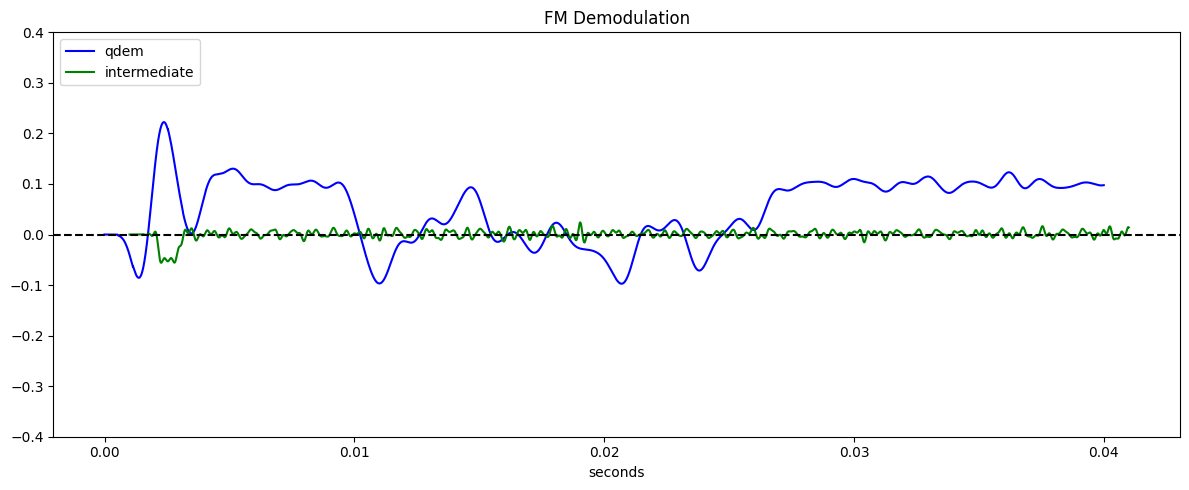

In [306]:
channel_freq = DPU_FREQS[0]
center_freq, fs, iq_data = open_recording_as_complex('recordings/hackrf_20250804_155723_455500000_8000000_i8c.raw', 5.75, .04)

t = np.arange(len(iq_data))
mixed = iq_data * np.exp(-2j * np.pi * ((channel_freq - center_freq) / fs) * t)

factor = 16
new_fs = fs // factor
downsampled = signal.decimate(mixed, factor)

fskbb = signal.lfilter(signal.firwin(1001, cutoff=5000, fs=new_fs), 1.0, downsampled)
# fskbb = downsampled

recovered_signal = qdem(fskbb) * 5
recovered_signal[:81] = 0

recovered_signal = signal.lfilter(signal.firwin(1001, cutoff=4000, fs=new_fs), 1.0, recovered_signal)

intermediate = recovered_signal
data = recovered_signal

t = np.arange(len(data))
mixed = data * np.exp(-2j * np.pi * (-1700 / new_fs) * t)

fskbb = signal.lfilter(signal.firwin(1001, cutoff=800, fs=new_fs), 1.0, mixed)

recovered_signal = qdem(fskbb) * 100
recovered_signal[:201] = 0

recovered_signal = signal.lfilter(signal.firwin(1001, cutoff=400, fs=new_fs), 1.0, recovered_signal)


plt.figure(figsize=(12, 5))

# recovered_signal, new_fs = fsk_demodulate(center_freq, fs, iq_data, channel_freq)
plt.plot(np.linspace(0, len(recovered_signal)/new_fs, len(recovered_signal)), recovered_signal, color='blue', label='qdem')
plt.plot(np.linspace(0, len(intermediate)/new_fs, len(intermediate))+500/new_fs, intermediate, color='green', label='intermediate')

# plt.plot(np.linspace(0, len(fskbb)/new_fs, len(fskbb)), np.real(fskbb) * 200, color='red', label='i')
# plt.plot(np.linspace(0, len(fskbb)/new_fs, len(fskbb)), np.imag(fskbb) * 200, color='orange', label='q')
# plt.scatter(np.linspace(0, len(fskbb)/new_fs, len(fskbb)), np.angle(fskbb) / (2*np.pi) * 0.5, color='green', s=5, label='phase')

display_max = 0.4

plt.axhline(0, color='black', linestyle='--')
plt.ylim(-display_max, display_max)
plt.xlabel('seconds')
plt.title('FM Demodulation')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

File: recordings/gqrx_20250804_210302_455500000_6000000_fc.raw, sample count: 1031798784 (85.98) seconds)


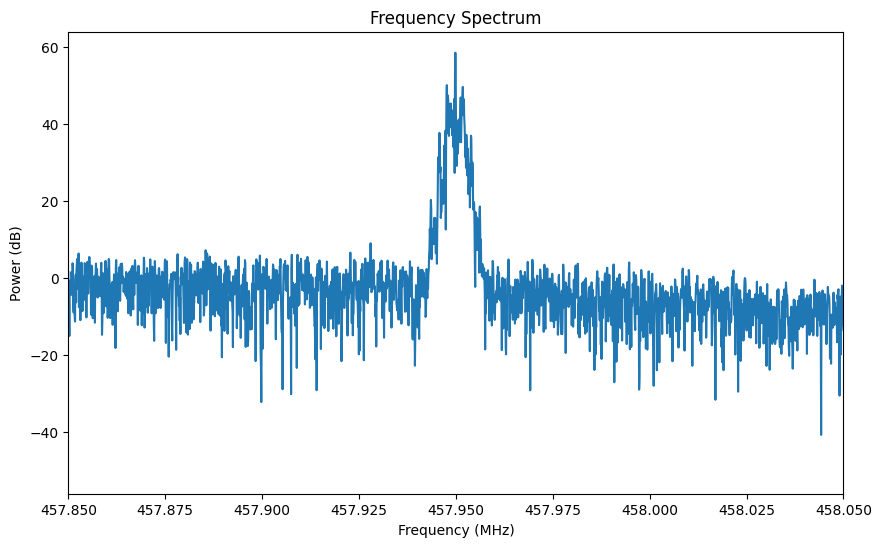

In [313]:
base = DPU_FREQS[3]/1e6
start = 29.1
draw_freq_spectrum('recordings/gqrx_20250804_210302_455500000_6000000_fc.raw', start, xlim=(base - .1, base + .1))

File: recordings/hackrf_20250804_155723_455500000_8000000_i8c.raw, sample count: 1492123648 (93.26) seconds)


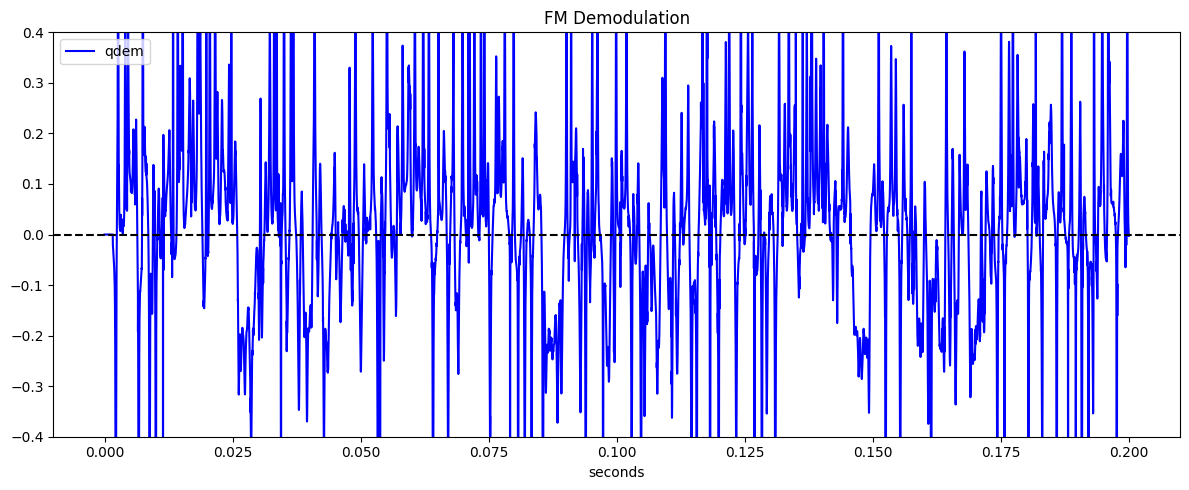

In [300]:
channel_freq = DPU_FREQS[1]
center_freq, fs, iq_data = open_recording_as_complex('recordings/hackrf_20250804_155723_455500000_8000000_i8c.raw', 5, .2)

plt.figure(figsize=(12, 5))

recovered_signal, new_fs = fsk_demodulate(center_freq, fs, iq_data, channel_freq)
plt.plot(np.linspace(0, len(recovered_signal)/new_fs, len(recovered_signal)), recovered_signal, color='blue', label='qdem')

display_max = 0.4

plt.axhline(0, color='black', linestyle='--')
plt.ylim(-display_max, display_max)
plt.xlabel('seconds')
plt.title('FM Demodulation')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [320]:
decode_dpu_bits('recordings/gqrx_20250804_210302_455500000_6000000_fc.raw', 28.8, .5, channel_id=3)

File: recordings/gqrx_20250804_210302_455500000_6000000_fc.raw, sample count: 1031798784 (85.98) seconds)


'0110111000100110100001010111000110001000110100110111111010000111110110000100100000010001010000001110001100010101000110001011001000010001011011101100110101000000000110110000010100000000011010100000110000000001100000000011000000000110000000001'

# Old old code

sample rate: 44100, audio duration: 87.36s


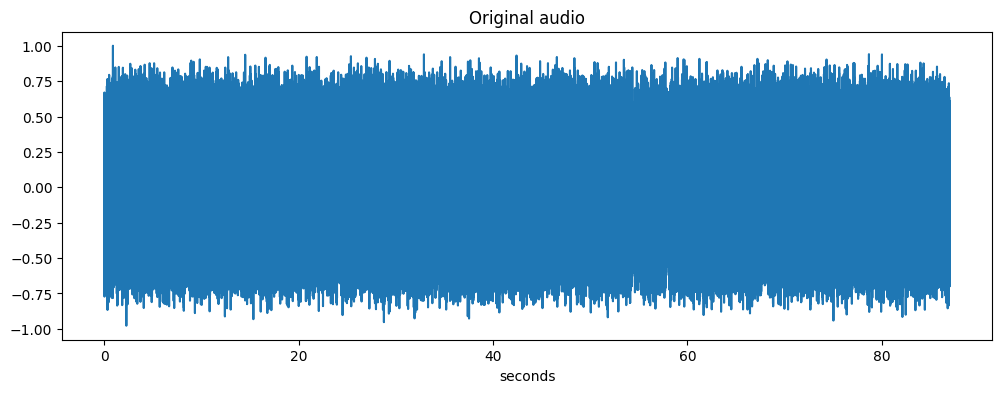

In [337]:
# wav_path = 'recordings/train3137_452.9250_2.wav'
wav_path = 'recordings/4579375_20250711_1206.wav'
fs, audio = wavfile.read(wav_path)
print(f'sample rate: {fs}, audio duration: {len(audio) / fs:.2f}s')

# If stereo, convert to mono
if len(audio.shape) > 1:
    audio = np.mean(audio, axis=1)

# Normalize audio to float in [-1, 1]
if audio.dtype != np.float32 and audio.dtype != np.float64:
    audio = audio / np.max(np.abs(audio))

plt.figure(figsize=(12, 4))
plt.plot(np.linspace(0, len(audio)//fs, len(audio)), audio)
plt.title('Original audio')
plt.xlabel('seconds')
plt.show()

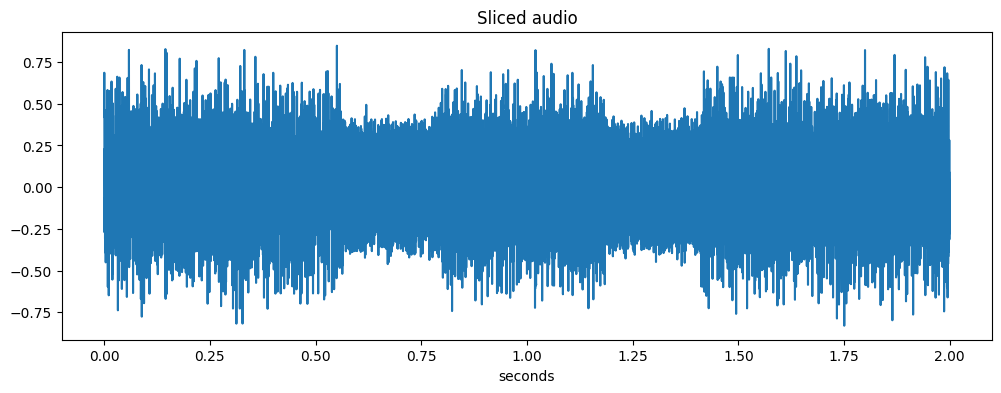

In [345]:
trim_start = 54
trim_end = trim_start + 2
trimmed_audio = audio[int(fs * trim_start):int(fs * trim_end)]

plt.figure(figsize=(12, 4))
plt.plot(np.linspace(0, len(trimmed_audio)/fs, len(trimmed_audio)), trimmed_audio)
plt.title('Sliced audio')
plt.xlabel('seconds')
plt.show()

[0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


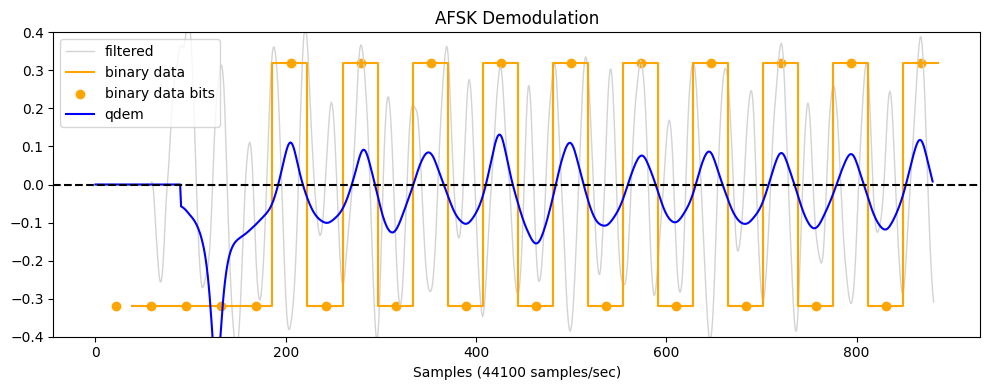

In [315]:
# Apply low-pass FIR filter using firwin and lfilter
fir_lp1 = signal.firwin(121, cutoff=10000, fs=fs)  # order 120
low_passed = signal.lfilter(fir_lp1, 1.0, trimmed_audio)

# Frequency shift (mixing)
t = np.arange(len(low_passed))
mixed = low_passed * np.exp(2j * np.pi * (-1550 / fs) * t)

# Apply a second low-pass filter to extract the baseband signal
fir_lp2 = signal.firwin(81, cutoff=600, fs=fs)  # order 80
fskbb = signal.lfilter(fir_lp2, 1.0, mixed)

# qdem (quadrature demodulation)
recovered_signal = qdem(fskbb) * 20
# initial portion of data is useless
recovered_signal[:90] = 0

baudrate = 1250
offset = fs / baudrate * 0.6
num_samples = int(len(trimmed_audio) / fs * baudrate) - 1
start = offset
end = offset + num_samples * fs/baudrate
baud = np.linspace(start, end, num_samples)

# data decoding
bin_data = ((np.sign(recovered_signal[baud.astype(int)]) + 1)/2).astype(int)
print(bin_data)


plt.figure(figsize=(10, 4))

# Plot the filtered waveform
plt.plot(low_passed, color='lightgray', linewidth=1, label='filtered')

display_max = 0.4
bin_display = ((bin_data*2 - 1)*display_max*0.8)
plt.step(baud + fs/baudrate/2, bin_display, color='orange', label='binary data')
plt.scatter(baud, bin_display, color='orange', label='binary data bits')

# plt.plot(np.real(fskbb))
# plt.plot(np.imag(fskbb))

plt.plot(recovered_signal, color='blue', label='qdem')

plt.axhline(0, color='black', linestyle='--')
plt.ylim(-display_max, display_max)
plt.title('AFSK Demodulation')
plt.xlabel(f'Samples ({fs} samples/sec)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [13]:
num_chunks = len(recovered_signal)//500
chunks = np.array(np.split(np.abs(recovered_signal)[:len(recovered_signal)//num_chunks*num_chunks], num_chunks))
np.sum(np.linalg.norm(chunks, axis=1, ord=np.inf) > 0.4) / num_chunks

np.float64(0.25)

# Old Cells

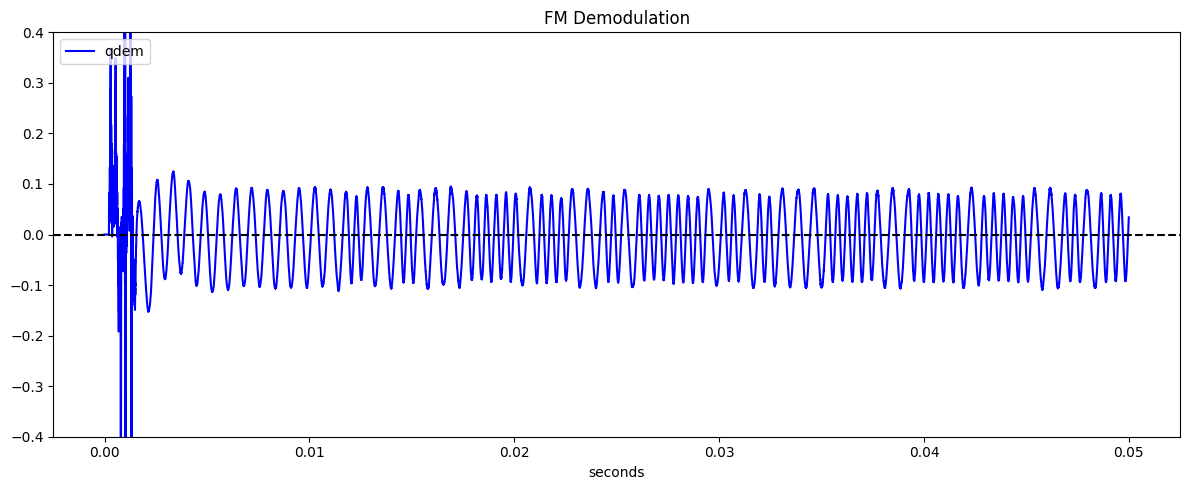

In [20]:
target_freq = int(457.95e6)
start_time = 2.98 # in seconds
duration = .05 # in seconds

if start_time * fs > len(iq_data):
    raise ValueError('start time after end of sample')

data = iq_data[int(start_time * fs):int((start_time + duration) * fs)]

t = np.arange(len(data))
mixed = data * np.exp(-2j * np.pi * ((target_freq - center_freq) / fs) * t)

factor = 16
new_fs = fs // factor
downsampled = signal.decimate(mixed, factor)

fir_lp2 = signal.firwin(81, cutoff=1000, fs=new_fs)  # order 80
fskbb = signal.lfilter(fir_lp2, 1.0, downsampled)

recovered_signal = qdem(fskbb) * 20
recovered_signal[:81] = 0

plt.figure(figsize=(12, 5))

display_max = 0.4
plt.plot(np.linspace(0, len(recovered_signal)/new_fs, len(recovered_signal)), recovered_signal, color='blue', label='qdem')

plt.axhline(0, color='black', linestyle='--')
plt.ylim(-display_max, display_max)
plt.xlabel('seconds')
plt.title('FM Demodulation')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

[1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1
 0 1 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 0 0
 1 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1 0 0 0
 1 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 0 1 1 0]


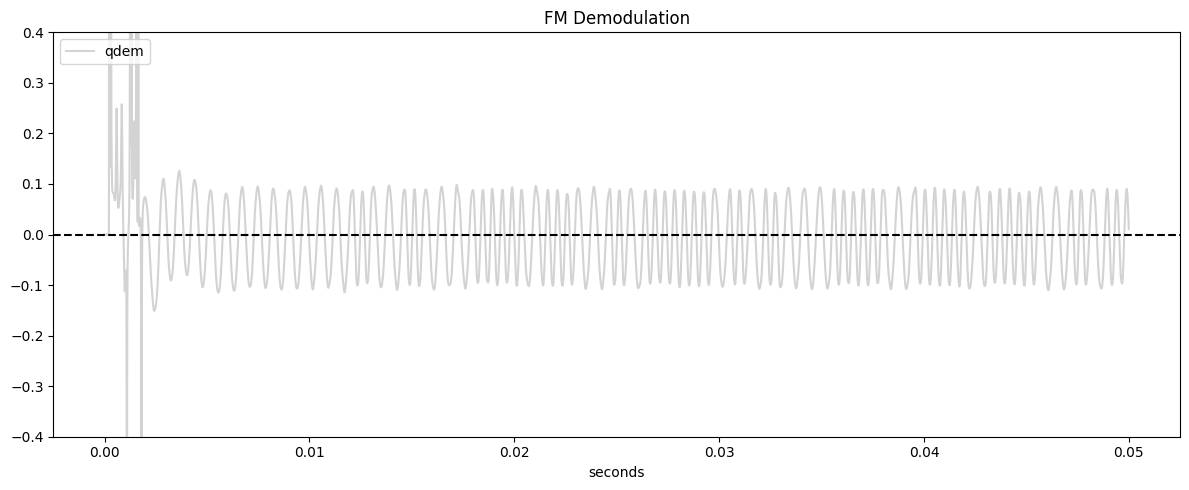

In [22]:
target_freq = int(457.95e6)
start_time = 2.98 # in seconds
duration = .05 # in seconds

if start_time * fs > len(iq_data):
    raise ValueError('start time after end of sample')

data = iq_data[int(start_time * fs):int((start_time + duration) * fs)]

t = np.arange(len(data))
mixed = data * np.exp(-2j * np.pi * ((target_freq - center_freq) / fs) * t)

factor = 16
new_fs = fs // factor
downsampled = signal.decimate(mixed, factor)

fir_lp2 = signal.firwin(301, cutoff=5000, fs=new_fs)  # order 80
fskbb = signal.lfilter(fir_lp2, 1.0, downsampled)

recovered_signal = qdem(fskbb) * 20
recovered_signal[:81] = 0

# recovered_signal = signal.lfilter(signal.firwin(1001, cutoff=1000, fs=new_fs), 1.0, recovered_signal) * 500

baudrate = 2650
offset = new_fs / baudrate * 0.7
num_samples = int(len(recovered_signal) / new_fs * baudrate) - 1
start = offset
end = offset + num_samples * new_fs/baudrate
baud = np.linspace(start, end, num_samples)
baudtime = baud/new_fs

# data decoding
bin_data = ((np.sign(recovered_signal[baud.astype(int)]) + 1)/2).astype(int)
print(bin_data)

plt.figure(figsize=(12, 5))

plt.plot(np.linspace(0, len(recovered_signal)/new_fs, len(recovered_signal)), recovered_signal, color='lightgray', label='qdem')

display_max = 0.4
bin_display = ((bin_data*2 - 1)*display_max*0.8)
# plt.step(baudtime + 1/baudrate/2, bin_display, color='orange', label='binary data')
# plt.scatter(baudtime, bin_display, color='orange', label='binary data bits')

plt.axhline(0, color='black', linestyle='--')
plt.ylim(-display_max, display_max)
plt.xlabel('seconds')
plt.title('FM Demodulation')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

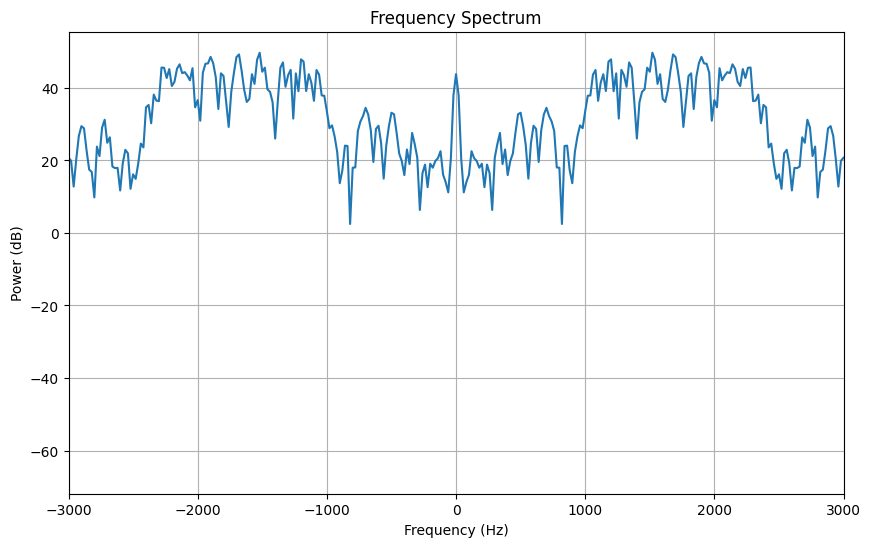

In [23]:
target_freq = int(457.95e6)
start_time = 2.98 # in seconds
duration = .05 # in seconds

if start_time * fs > len(iq_data):
    raise ValueError('start time after end of sample')

data = iq_data[int(start_time * fs):int((start_time + duration) * fs)]

t = np.arange(len(data))
mixed = data * np.exp(-2j * np.pi * ((target_freq - center_freq) / fs) * t)

factor = 16
new_fs = fs // factor
downsampled = signal.decimate(mixed, factor)

fir_lp2 = signal.firwin(81, cutoff=1000, fs=new_fs)  # order 80
fskbb = signal.lfilter(fir_lp2, 1.0, downsampled)

recovered_signal = qdem(fskbb) * 50
recovered_signal[:81] = 0

data = recovered_signal
window = np.hanning(len(data))
windowed_data = data * window

# FFT
spectrum = np.fft.fftshift(np.fft.fft(windowed_data))
frequencies = np.fft.fftshift(np.fft.fftfreq(len(spectrum), d=1/new_fs))  # adjust for sample rate
power = 20 * np.log10(np.abs(spectrum) + 1e-10)  # in dB

plt.figure(figsize=(10, 6))

plt.plot(frequencies, power)
plt.title("Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.xlim(-3000, 3000)
plt.grid(True)
plt.show()

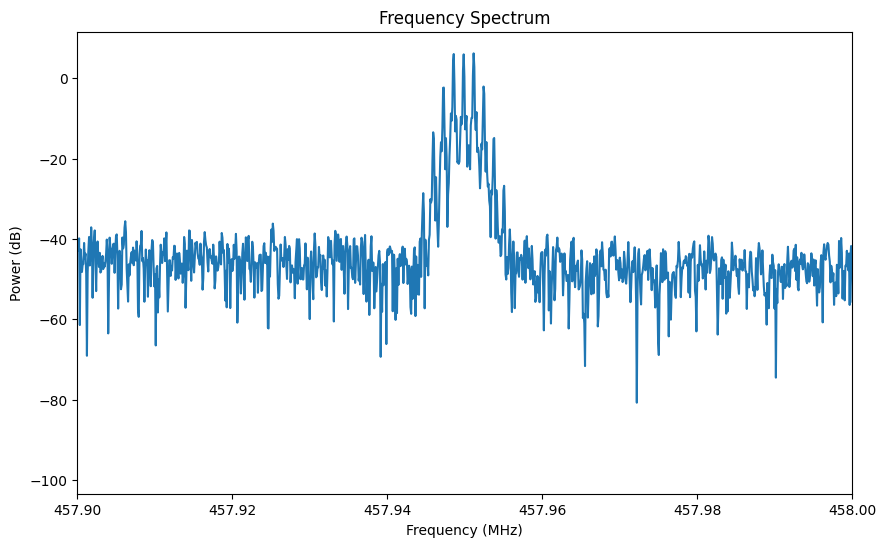

In [27]:
# Apply window to reduce spectral leakage
# max_data_size = fs//4
max_data_size = 2048 * 32
chunk_index = int(fs/max_data_size * 2.99)
data = iq_data[chunk_index * max_data_size:(chunk_index + 1) * max_data_size]
window = np.hanning(len(data))
windowed_data = data * window

# FFT
spectrum = np.fft.fftshift(np.fft.fft(windowed_data))
frequencies = np.fft.fftshift(np.fft.fftfreq(len(spectrum), d=1/fs))  # adjust for sample rate
power = 20 * np.log10(np.abs(spectrum) + 1e-10)  # in dB

plt.figure(figsize=(10, 6))

min_freq = 457.9
max_freq = min_freq + 0.1
plt.xlim(min_freq, max_freq)

plt.plot((frequencies + center_freq)/1e6, power)
plt.title("Frequency Spectrum")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dB)")
plt.show()

File: recordings/gqrx_20250804_210302_455500000_6000000_fc.raw, sample count: 1031798784 (85.98) seconds)
0110111000100110100001010111000110001000110100110111111010000111110110000100100000010001010000001110001100010101000110001011001000010001011011101100110101000000000110110000010100000000011010100000110000000001100000000011000000000110000000001100000000011010000000010100100010101011001011011100010110001100001100000010111110001110010110110011101010111110011011010001001010111110111101001110111010100011100100111101111110100111101101011010001101100111111011111001111101001101100110100
0.11698622986184226 2.1683240908279875 488


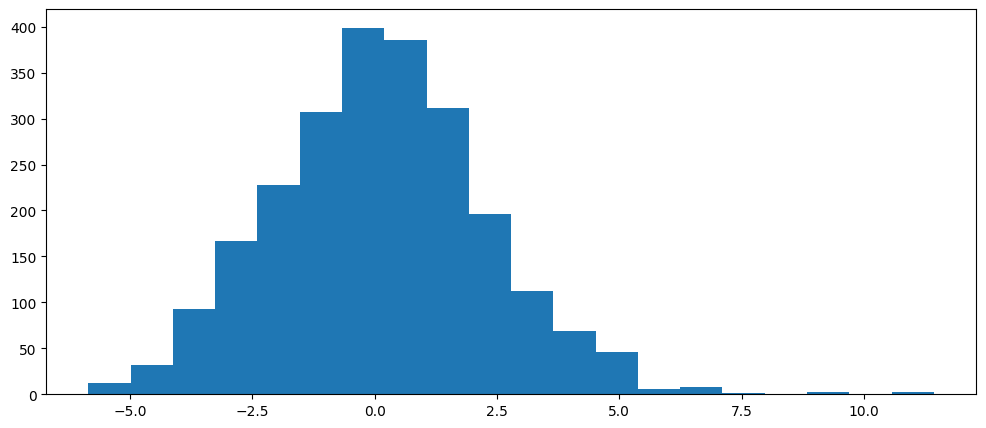

46873 2467 19 93750


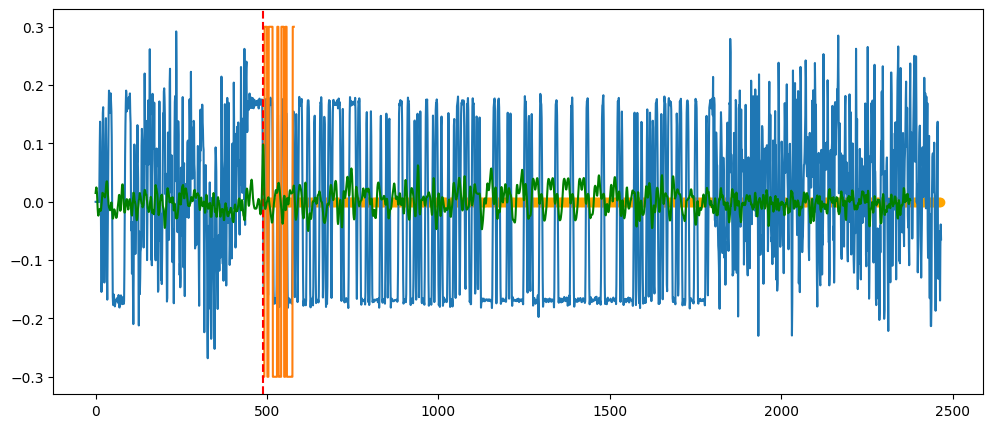

<Figure size 1200x500 with 0 Axes>

In [149]:
channel_freq = int(457.95e6)
fname = 'recordings/gqrx_20250804_210302_455500000_6000000_fc.raw'

start_time = 29.0 # in seconds
duration = .5 # in seconds

center_freq, fs, iq_data = open_recording_as_complex(fname, start_time, duration)

plt.figure(figsize=(12, 5))

fsk, fs = fsk_demodulate(center_freq, fs, iq_data, channel_freq)

# discard extreme values
fsk[np.abs(fsk) > 0.3] = 0

baudrate = 1200
frame_sync = '0110111000100110100001'
frame_sync_bits = np.array([int(c) for c in frame_sync])
framesync = np.repeat((frame_sync_bits * 2) - 1, fs//baudrate)


# 10 means shift the frame sync by 1/10 of a baud at a time when searching
frame_sync_discovery_factor = 4

factor = fs//baudrate//frame_sync_discovery_factor
downsampled_signal = signal.decimate(fsk, factor)
# downsampled_framesync = signal.decimate(framesync, factor)
downsampled_framesync = framesync[::factor]

score = np.convolve(downsampled_signal, downsampled_framesync[::-1], mode='valid')

framesync_matched = np.argmax(score)

baud_period = fs/factor/baudrate
indices = np.arange(framesync_matched + baud_period//2, len(downsampled_signal), baud_period).astype(int)
extracted_data = (np.sign(downsampled_signal[indices]) + 1)/2
data_bin = ''.join(str(int(c)) for c in extracted_data)
print(data_bin)
assert data_bin.startswith(frame_sync), 'was framesync not a perfect match?'

print(np.mean(score), np.std(score), framesync_matched)
plt.hist(score, bins=20)
plt.show()

print(len(fsk), len(downsampled_signal), factor, fs)
plt.figure(figsize=(12, 5))
plt.plot(downsampled_signal)
plt.plot(np.arange(0, len(downsampled_framesync)) + framesync_matched, downsampled_framesync * 0.3)
plt.axvline(framesync_matched, color='r', linestyle='--')
visbaud = np.arange(framesync_matched + baud_period//2, len(downsampled_signal), baud_period)
plt.scatter(visbaud, np.zeros(visbaud.shape), color='orange')
plt.plot(score / 35 * 0.3, linestyle='-', color='green')
# plt.xlim(1400, 1500)
# plt.xlim(550, 700)
plt.show()

plt.figure(figsize=(12, 5))
plt.show()

In [109]:
d = ''.join(map(str, bin_data.tolist()))
print(f'{d=}')
frame_sync = '0110111000100110100001'
search = frame_sync
print(f'{frame_sync=} {search=}')

start_index = 0
while True:
    index = d.find(search, start_index)
    if index == -1:  # Substring not found
        break
    print(f'FOUND {index=} str: {d[index-10:index+len(search)+10]}')
    start_index = index + 1  # Start searching from the next character

d='00111111111111101101110001001101000010101110001100010001101001101111110100001111101100001001001111100010100000011101011'
frame_sync='0110111000100110100001' search='0110111000100110100001'
FOUND index=15 str: 111111111101101110001001101000010101110001


In [466]:
frame_sync_nums = np.array([int(c) for c in frame_sync])
framesync = np.repeat((frame_sync_nums * 2) - 1, new_fs/baudrate)

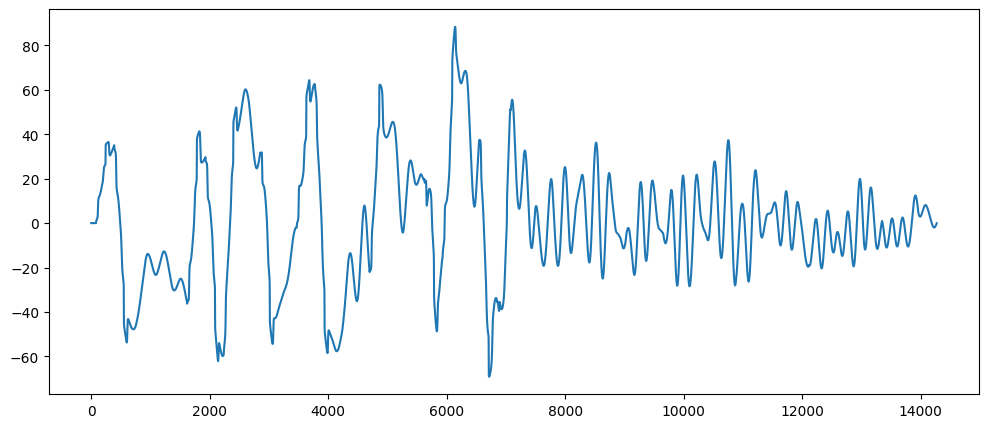

In [502]:
locs = np.convolve(recovered_signal, framesync[::-1])
# plt.hist(np.argsort(locs)[:-1000:-1])
plt.figure(figsize=(12, 5))
plt.plot(locs)

[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 0]


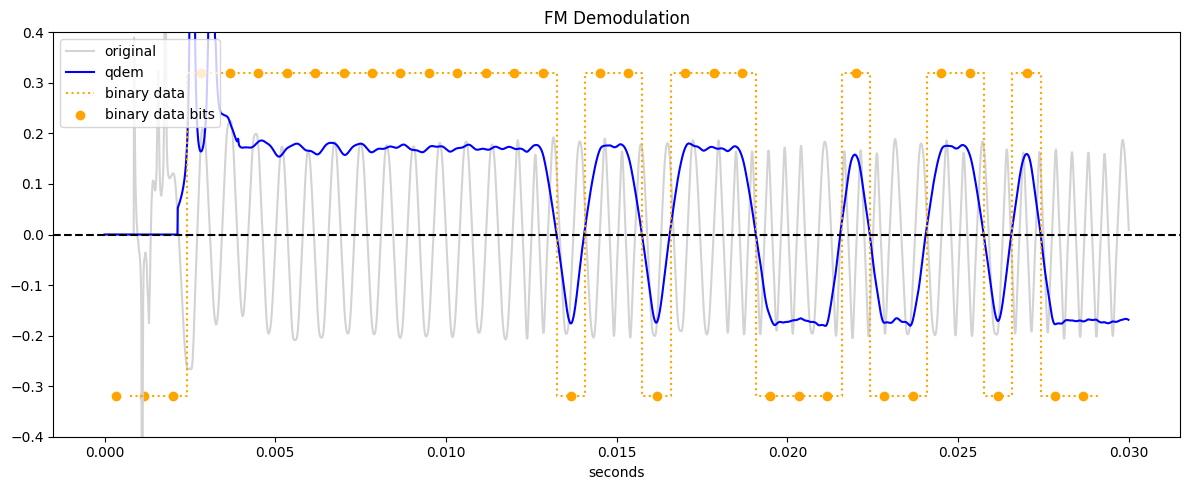

In [144]:
target_freq = int(457.95e6)
start_time = 29.5 # in seconds
duration = .5 # in seconds

center_freq, fs, iq_data = open_recording_as_complex(fname, start_time, duration)

t = np.arange(len(iq_data))
mixed = iq_data * np.exp(-2j * np.pi * ((target_freq - center_freq) / fs) * t)

factor = 64
new_fs = fs // factor
downsampled = signal.decimate(mixed, factor)

fskbb = signal.lfilter(signal.firwin(81, cutoff=3000, fs=new_fs), 1.0, downsampled)

recovered_signal = qdem(fskbb) * 10
recovered_signal[:81] = 0

intermediate = recovered_signal
data = recovered_signal

t = np.arange(len(data))
mixed = data * np.exp(-2j * np.pi * (-1700 / new_fs) * t)

fskbb = signal.lfilter(signal.firwin(201, cutoff=800, fs=new_fs), 1.0, mixed)

recovered_signal = qdem(fskbb) * 40
recovered_signal[:201] = 0

baudrate = 1200
offset = new_fs / baudrate * 0.4
num_samples = int(len(recovered_signal) / new_fs * baudrate)
start = offset
end = offset + (num_samples - 1) * new_fs/baudrate
baud = np.linspace(start, end, num_samples)
# print(f'{num_samples=}, {offset=}, {baud[1]-baud[0]=}, {baud=}')
baudtime = baud/new_fs

# data decoding
bin_data = ((np.sign(recovered_signal[baud.astype(int)]) + 1)/2).astype(int)
print(bin_data)

plt.figure(figsize=(12, 5))

plt.plot(np.linspace(0, len(intermediate)/new_fs, len(intermediate)), intermediate, color='lightgray', label='original')
plt.plot(np.linspace(0, len(recovered_signal)/new_fs, len(recovered_signal)), recovered_signal, color='blue', label='qdem')

display_max = 0.4
bin_display = ((bin_data*2 - 1)*display_max*0.8)
plt.step(baudtime + 1/baudrate/2, bin_display, linestyle=':', color='orange', label='binary data')
plt.scatter(baudtime, bin_display, color='orange', label='binary data bits')

plt.axhline(0, color='black', linestyle='--')
plt.ylim(-display_max, display_max)
plt.xlabel('seconds')
plt.title('FM Demodulation')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()